In [38]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.activations import relu, softmax, sigmoid, swish
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50  import preprocess_input

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [4]:
# load and iterate training dataset
train_data = train_datagen.flow_from_directory('/local/data1/chash345/train', 
    class_mode='binary',
    target_size=(224, 224), 
    batch_size=32, 
    shuffle=False,
    color_mode='rgb'
)

# load and iterate validation dataset
val_data = validation_datagen.flow_from_directory('/local/data1/chash345/valid', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32, 
    shuffle=False,
    color_mode='rgb'
)

# load and iterate test dataset
test_data = test_datagen.flow_from_directory('/local/data1/chash345/test', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=8, 
    shuffle=False,
    color_mode='rgb'
)

Found 2600 images belonging to 2 classes.
Found 870 images belonging to 2 classes.
Found 864 images belonging to 2 classes.


The dimensions of the image are 224 pixels width and 224 pixels height, one single color channel.
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.3732 and the standard deviation is 0.3433


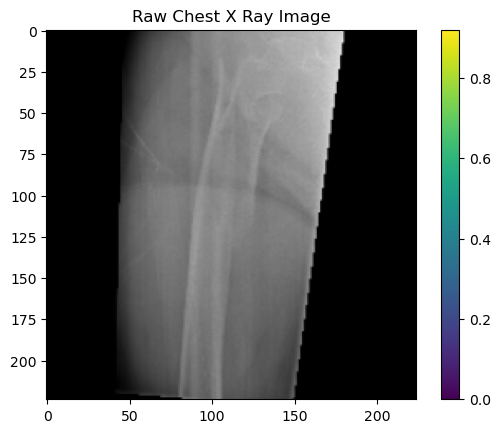

In [5]:
#sns.set_style('white')
generated_image, label = train_data.__getitem__(24)
plt.imshow(generated_image[7])

plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [6]:
generated_image.shape

(32, 224, 224, 3)

In [8]:
pre_trained_model = VGG19(input_shape=(224,224,3),
                                include_top=False,
                                weights="imagenet")

# Some weights in later layers are unfreezed
for layer in pre_trained_model.layers[:-5]:
    layer.trainable=False

tf.random.set_seed(100)

model = tf.keras.models.Sequential([
    pre_trained_model,
    Flatten(),    
    Dense(512,activation="swish"),
    Dropout(0.5),
    # Dense(256,activation="relu"),
    # Dropout(0.5),
    Dense(128, activation='relu'),  
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=['accuracy'])

2022-12-29 08:16:12.383611: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 08:16:12.383896: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


80142336/80134624 [==============================] - 3s 0us/step


2022-12-29 08:16:18.158458: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.
2022-12-29 08:16:18.215786: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.
2022-12-29 08:16:18.225810: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 32,935,745
Trainable params: 22,350,593
Non-trainable params: 10,585,152
___________________________________

In [10]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(class_weight= 'balanced', y =train_data.classes, classes=np.unique(train_data.classes))
dict_weights = {0: weights[0], 1:weights[1]}
dict_weights

{0: 2.5, 1: 0.625}

In [10]:
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data, 
    class_weight=dict_weights 
)

2022-12-20 18:41:20.065872: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-20 18:41:20.066262: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3492035000 Hz


Epoch 1/10


2022-12-20 18:41:20.895525: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-20 18:43:17.945142: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [7]:
reconstructed_model = keras.models.load_model("saved_model")

2022-12-30 09:57:06.560701: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-30 09:57:06.560939: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-30 09:57:06.573672: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.
2022-12-30 09:57:06.631222: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.
2022-12-30 09:57:06.639216: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.
2022-12-30 09:57:07.409221: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Al

In [8]:
predcited_classes = reconstructed_model.predict_classes(test_data)

/home/chash345/.conda/envs/research/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-12-30 09:57:15.781663: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-30 09:57:15.782092: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3492035000 Hz


In [9]:
predicted_probs = reconstructed_model.predict(test_data)

In [29]:
y_true = test_data.classes

In [30]:
y_pred = predcited_classes.reshape(1, len(test_data.classes))

In [36]:
confusion_matrix(y_true= y_true , y_pred=y_pred[0])

array([[133,  40],
       [213, 478]])

In [39]:
pd.DataFrame(classification_report(y_true, y_pred[0], output_dict=True)).T

,precision,recall,f1-score,support
0,0.384393,0.768786,0.512524,173.000000
1,0.922780,0.691751,0.790736,691.000000
accuracy,0.707176,0.707176,0.707176,0.707176
macro avg,0.653586,0.730269,0.651630,864.000000
weighted avg,0.814978,0.707176,0.735029,864.000000


In [40]:
fpr, tpr, thresholds = roc_curve(test_data.classes, predcited_classes)

In [41]:
roc_auc_score(test_data.classes, predicted_probs )

0.783324828722719

In [42]:
roc_auc_score(test_data.classes, predcited_classes )

0.7302686062755661

In [43]:
roc_auc = auc(fpr, tpr)

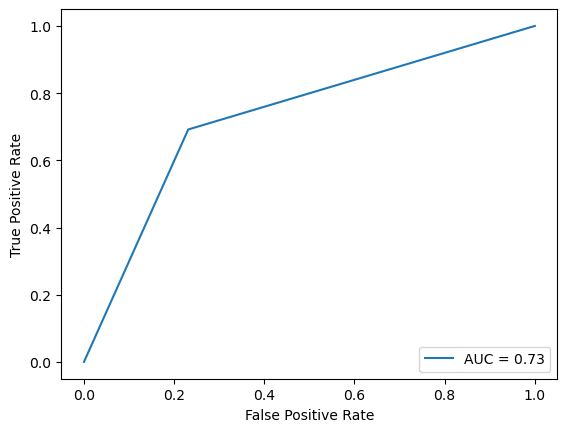

In [44]:
display = RocCurveDisplay(fpr=fpr,tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()